<a href="https://colab.research.google.com/github/skywalker0803r/Microsoft-DAT257x-Reinforcement-Learning-Explained/blob/master/Ex2_1A_Greedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT257x: Reinforcement Learning Explained

## Lab 2: Bandits

### Exercise 2.1A: Greedy policy

In [0]:
import numpy as np
import sys

### Interface
class Environment(object):

    def reset(self):
        raise NotImplementedError('Inheriting classes must override reset.')

    def actions(self):
        raise NotImplementedError('Inheriting classes must override actions.')

    def step(self):
        raise NotImplementedError('Inheriting classes must override step')

class ActionSpace(object):
    
    def __init__(self, actions):
        self.actions = actions
        self.n = len(actions)
        
### BanditEnv Environment
        
class BanditEnv(Environment):
    def __init__(self, num_actions = 10, distribution = "bernoulli", evaluation_seed="387"):
        super(BanditEnv, self).__init__()
        
        self.action_space = ActionSpace(range(num_actions))
        self.distribution = distribution
        
        np.random.seed(evaluation_seed)
        
        self.reward_parameters = None
        if distribution == "bernoulli":
            self.reward_parameters = np.random.rand(num_actions)
        elif distribution == "normal":
            self.reward_parameters = (np.random.randn(num_actions), np.random.rand(num_actions))
        elif distribution == "heavy-tail":
            self.reward_parameters = np.random.rand(num_actions)
        else:
            print("Please use a supported reward distribution", flush = True)
            sys.exit(0)
        
        if distribution != "normal":
            self.optimal_arm = np.argmax(self.reward_parameters)
        else:
            self.optimal_arm = np.argmax(self.reward_parameters[0])
    
    def reset(self):
        self.is_reset = True
        return None
    
    def compute_gap(self, action):
        if self.distribution != "normal":
            gap = np.absolute(self.reward_parameters[self.optimal_arm] - self.reward_parameters[action])
        else:
            gap = np.absolute(self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action])
        return gap
    
    def step(self, action):
        self.is_reset = False
        
        valid_action = True
        if (action is None or action < 0 or action >= self.action_space.n):
            print("Algorithm chose an invalid action; reset reward to -inf", flush = True)
            reward = float("-inf")
            gap = float("inf")
            valid_action = False
        
        if self.distribution == "bernoulli":
            if valid_action:
                reward = np.random.binomial(1, self.reward_parameters[action])
                gap = self.reward_parameters[self.optimal_arm] - self.reward_parameters[action]
        elif self.distribution == "normal":
            if valid_action:
                reward = self.reward_parameters[0][action] + self.reward_parameters[1][action] * np.random.randn()
                gap = self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action]
        elif self.distribution == "heavy-tail":
            if valid_action:
                reward = self.reward_parameters[action] + np.random.standard_cauchy()
                gap = self.reward_parameters[self.optimal_arm] - self.reward_parameters[action]        #HACK to compute expected gap
        else:
            print("Please use a supported reward distribution", flush = True)
            sys.exit(0)
            
        return(None, reward, self.is_reset, '')

In [0]:
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_running_variance"])
TimestepStats = namedtuple("Stats",["cumulative_rewards", "regrets"])

def plot_episode_stats(stats, smoothing_window=10, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig1, fig2

def plot_pgresults(stats, smoothing_window=20, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
       
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_running_variance)
    plt.xlabel("Episode")
    plt.ylabel("Running Variance")
    plt.title("Running Variance over Time")
    if hideplot:
        plt.close(fig3)
    else:
        plt.show(fig3)
        
    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), np.cumsum(stats.episode_lengths))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

def plot_dqnresults(stats, smoothing_window=20, hideplot=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
              
    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(stats.episode_lengths)), np.cumsum(stats.episode_lengths))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

def plot_reward_regret(stats, smoothing_window=1, hideplot=False):
    # Plot the cumulative reward over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.cumulative_rewards)
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Reward over Timestep")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the regret over time
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(stats.regrets)
    plt.xlabel("Timestep")
    plt.ylabel("Regret")
    plt.title("Regret over Timestep")
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
             
    return fig1, fig2   

def plot_arm_rewards(y, hideplot=False):
    
    N = len(y)
    x = range(N)
    width = 1/1.5
    
    fig1 = plt.figure(figsize=(10,5))
    plt.bar(x, y, width)
    
    plt.xlabel("Arm")
    plt.ylabel("Probability")
    plt.title("Arm's Reward Distribution")
    
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)
             
    return fig1   

In [0]:
import numpy as np
import sys
#import lib.plotting as plotting
from matplotlib import pyplot as plt
from matplotlib import pylab
import matplotlib.gridspec as gridspec

class Experiment(object):
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
        
        self.episode_length = np.array([0])
        self.episode_reward = np.array([0])
        
        self.fig = pylab.figure(figsize=(10, 5))
        gs = gridspec.GridSpec(2, 2)
        self.ax = pylab.subplot(gs[:, 0])
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        
        if hasattr(self.env, '_cliff'): # Hardcode to nicely display grid for cliffwalkingenv
            self.ax.xaxis.set_visible(True)
            self.ax.yaxis.set_visible(True)
            self.ax.set_xticks(np.arange(-.5, 12, 1), minor=True);
            self.ax.set_yticks(np.arange(-.5, 4, 1), minor=True);
            self.ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
            
        if hasattr(self.env, 'winds'): # Hardcode to nicely display grid for windygridworldenv
            self.ax.xaxis.set_visible(True)
            self.ax.yaxis.set_visible(True)
            self.ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
            self.ax.set_yticks(np.arange(-.5, 7, 1), minor=True);
            self.ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        
        self.ax1 = pylab.subplot(gs[0, 1])
        self.ax1.yaxis.set_label_position("right")
        self.ax1.set_ylabel('Length')
        
        self.ax1.set_xlim(0, max(10, len(self.episode_length)+1))
        self.ax1.set_ylim(0, 51)
        
        self.ax2 = pylab.subplot(gs[1, 1])
        self.ax2.set_xlabel('Episode')
        self.ax2.yaxis.set_label_position("right")
        self.ax2.set_ylabel('Reward')
        self.ax2.set_xlim(0, max(10, len(self.episode_reward)+1))
        self.ax2.set_ylim(0, 2)
        
        self.line, = self.ax1.plot(range(len(self.episode_length)),self.episode_length)
        self.line2, = self.ax2.plot(range(len(self.episode_reward)),self.episode_reward)
        
    def update_display_step(self):
        if not hasattr(self, 'imgplot'):
            self.imgplot = self.ax.imshow(self.env.render(mode='rgb_array'), interpolation='none', cmap='viridis')
        else:
            self.imgplot.set_data(self.env.render(mode='rgb_array'))
    
        self.fig.canvas.draw()
        
    def update_display_episode(self):  
        self.line.set_data(range(len(self.episode_length)),self.episode_length)
        self.ax1.set_xlim(0, max(10, len(self.episode_length)+1))
        self.ax1.set_ylim(0, max(self.episode_length)+1)
        
        self.line2.set_data(range(len(self.episode_reward)),self.episode_reward)
        self.ax2.set_xlim(0, max(10, len(self.episode_reward)+1))
        self.ax2.set_ylim(min(self.episode_reward)-1, max(self.episode_reward)+1)
        
        self.fig.canvas.draw()     
        
    def run_bandit(self, max_number_of_trials=1000, display_frequency=1):
        self.fig.clf()
        
        print("Distribution:", self.env.distribution, self.env.reward_parameters, flush = True)
        print("Optimal arm:", self.env.optimal_arm, flush = True)
        
        if self.env.distribution != "normal":
            plot_arm_rewards(self.env.reward_parameters)
        #else:
            #plotting.plot_arm_rewards(self.env.reward_parameters[0])
        
        stats = TimestepStats(
            cumulative_rewards=np.zeros(max_number_of_trials),
            regrets=np.zeros(max_number_of_trials))   
            
        cumulative_reward = 0.0
        cumulative_regret = 0.0
        
        for trial in range(max_number_of_trials):
            action = self.agent.act()
            
            _ , reward, done, _ = self.env.step(action)       
            self.agent.feedback(action, reward)
            cumulative_reward += reward

            gap = self.env.compute_gap(action)
            if action != self.env.optimal_arm:
                cumulative_regret += gap

            stats.cumulative_rewards[trial] = cumulative_reward
            stats.regrets[trial] = cumulative_regret

        print("--------------------------------------------------", flush = True)
        print("Policy:", self.agent.name, "\nAverage Reward:", cumulative_reward / max_number_of_trials, \
                "\nAverage Regret:", cumulative_regret / max_number_of_trials, flush = True)
        print("Arm pulls:", self.agent.total_counts, flush = True)
         
        plot_reward_regret(stats)
        
    def run_agent(self, max_number_of_episodes=100, interactive = False, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()
            
            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                # increase step counter - for display
                t += 1
                
                # choose action from state 
                action = self.agent.act(state)
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # state <- next state
                state = next_state
                
                R += reward # accumulate reward - for display
                
                # if interactive display, show update for each step
                if interactive:
                    self.update_display_step()
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 
            
            # if interactive display, show update for the episode
            if interactive:
                self.update_display_episode()
        
        # if not interactive display, show graph at the end
        if not interactive:
            self.fig.clf()
            stats = EpisodeStats(
                episode_lengths=self.episode_length,
                episode_rewards=self.episode_reward,
                episode_running_variance=np.zeros(max_number_of_episodes))
            plot_episode_stats(stats, display_frequency)
        
  
    def run_qlearning(self, max_number_of_episodes=100, interactive = False, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()
            
            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                t += 1 # increase step counter - for display
                
                # choose action from state using policy derived from Q
                action = self.agent.act(state)
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # agent learn (Q-Learning update)
                self.agent.learn(state, action, reward, next_state, done)
                
                # state <- next state
                state = next_state
                
                R += reward # accumulate reward - for display
                
                # if interactive display, show update for each step
                if interactive:
                    self.update_display_step()
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 
            
            # if interactive display, show update for the episode
            if interactive:
                self.update_display_episode()
        
        # if not interactive display, show graph at the end
        if not interactive:
            self.fig.clf()
            stats = EpisodeStats(
                episode_lengths=self.episode_length,
                episode_rewards=self.episode_reward,
                episode_running_variance=np.zeros(max_number_of_episodes))
            plot_episode_stats(stats, display_frequency)
            
    def run_sarsa(self, max_number_of_episodes=100, interactive = False, display_frequency=1):

        # repeat for each episode
        for episode_number in range(max_number_of_episodes):
            
            # initialize state
            state = self.env.reset()

            done = False # used to indicate terminal state
            R = 0 # used to display accumulated rewards for an episode
            t = 0 # used to display accumulated steps for an episode i.e episode length
            
            # choose action from state using policy derived from Q
            action = self.agent.act(state)
            
            # repeat for each step of episode, until state is terminal
            while not done:
                
                t += 1 # increase step counter - for display
                
                # take action, observe reward and next state
                next_state, reward, done, _ = self.env.step(action)
                
                # choose next action from next state using policy derived from Q
                next_action = self.agent.act(next_state)
                
                # agent learn (SARSA update)
                self.agent.learn(state, action, reward, next_state, next_action)
                
                # state <- next state, action <- next_action
                state = next_state
                action = next_action

                R += reward # accumulate reward - for display
                
                # if interactive display, show update for each step
                if interactive:
                    self.update_display_step()
            
            self.episode_length = np.append(self.episode_length,t) # keep episode length - for display
            self.episode_reward = np.append(self.episode_reward,R) # keep episode reward - for display 
            
            # if interactive display, show update for the episode
            if interactive:
                self.update_display_episode()
        
        # if not interactive display, show graph at the end
        if not interactive:
            self.fig.clf()
            stats = EpisodeStats(
                episode_lengths=self.episode_length,
                episode_rewards=self.episode_reward,
                episode_running_variance=np.zeros(max_number_of_episodes))
            plot_episode_stats(stats, display_frequency)

In [0]:
import numpy as np
import sys

if "../" not in sys.path:
    sys.path.append("../") 

#from lib.envs.bandit import BanditEnv
#from lib.simulation import Experiment

Let's define an interface of a policy. For a start, the policy should know how many actions it can take and able to take a particular action given that policy

In [0]:
#Policy interface
class Policy:
    #num_actions: (int) Number of arms [indexed by 0 ... num_actions-1]
    def __init__(self, num_actions):
        self.num_actions = num_actions
    
    def act(self):
        pass
        
    def feedback(self, action, reward):
        pass

Now let's implement a greedy policy based on the policy interface. The greedy policy will take the most rewarding action (i.e greedy). This is implemented in the act() function. In addition, we will maintain the name of the policy (name), the rewards it has accumulated for each action (total_rewards), and the number of times an action has been performed (total_counts).

In [0]:
#Greedy policy
class Greedy(Policy):
    def __init__(self, num_actions):
        Policy.__init__(self, num_actions)
        self.name = "Greedy"
        self.total_rewards = np.zeros(num_actions, dtype = np.longdouble)
        self.total_counts = np.zeros(num_actions, dtype = np.longdouble)
    
    def act(self):
        current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
        current_averages[self.total_counts <= 0] = 0.5      #Correctly handles Bernoulli rewards; over-estimates otherwise
        current_action = np.argmax(current_averages)
        return current_action
        
    def feedback(self, action, reward):
        self.total_rewards[action] += reward
        self.total_counts[action] += 1

We are now ready to perform our first simulation. Let's set some parameters.

In [0]:
evaluation_seed = 8026
num_actions = 5
trials = 10000
distribution = "bernoulli"

Now, put the pieces together and run the experiment.

Distribution: bernoulli [0.4561754  0.22507755 0.82070893 0.05221751 0.03428511]
Optimal arm: 2


<Figure size 720x360 with 0 Axes>

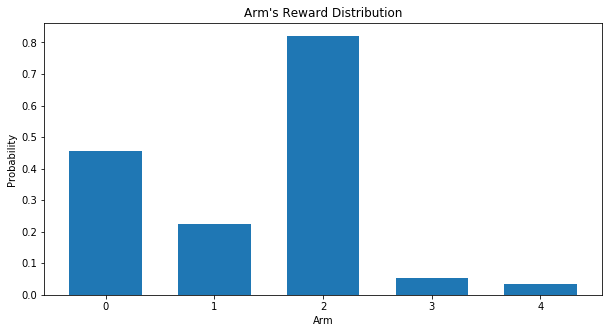

--------------------------------------------------
Policy: Greedy 
Average Reward: 0.4586 
Average Regret: 0.3646027658185429
Arm pulls: [9.996e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00]


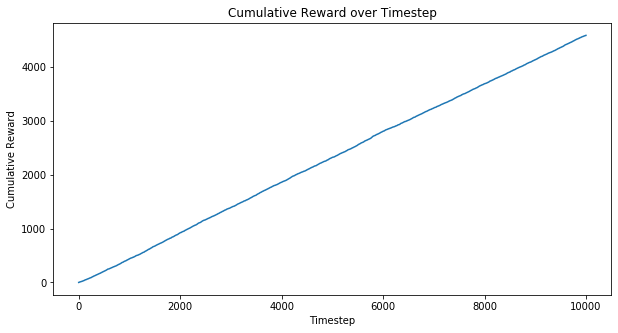

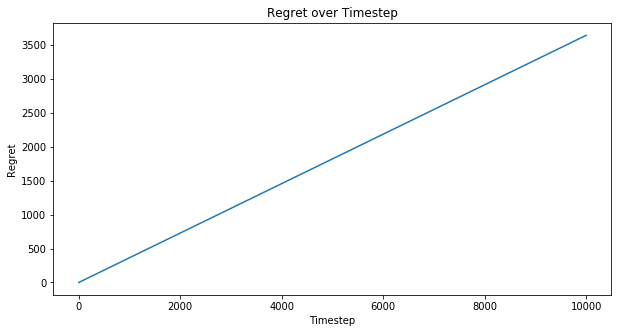

In [8]:
env = BanditEnv(num_actions, distribution, evaluation_seed)
agent = Greedy(num_actions)
experiment = Experiment(env, agent)
experiment.run_bandit(trials)

Observe the above results and answer the lab questions!